In [1]:
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.nn.functional as F
import os  

group_number = 4
train_path = f'../../data_preprocess/dataset/{group_number}/train.csv'
valid_path = f'../../data_preprocess/dataset/{group_number}/valid.csv'
test_path = f'../../translation/0.result/{group_number}/test_p.csv'
output_path = f'0.class_document/bert-tiny/{group_number}/test_p_c.csv'  # 디렉토리 변경

# 데이터 읽기
train_data = pd.read_csv(train_path)
valid_data = pd.read_csv(valid_path)
test_data = pd.read_csv(test_path)

# thing_property 필드 추가
train_data['thing_property'] = train_data['thing'] + '_' + train_data['property']
valid_data['thing_property'] = valid_data['thing'] + '_' + valid_data['property']
test_data['thing_property'] = test_data['thing'] + '_' + test_data['property']

# 토크나이저 및 레이블 인코더 설정
tokenizer = BertTokenizer.from_pretrained('prajjwal1/bert-tiny')  # 모델 변경
label_encoder = LabelEncoder()
label_encoder.fit(train_data['thing_property'])

# 새로운 레이블 처리
valid_data['thing_property'] = valid_data['thing_property'].apply(
    lambda x: x if x in label_encoder.classes_ else 'unknown_label')
test_data['thing_property'] = test_data['thing_property'].apply(
    lambda x: x if x in label_encoder.classes_ else 'unknown_label')

# 'unknown_label' 추가
label_encoder.classes_ = np.append(label_encoder.classes_, 'unknown_label')

# 레이블 인코딩
train_data['label'] = label_encoder.transform(train_data['thing_property'])
valid_data['label'] = label_encoder.transform(valid_data['thing_property'])
test_data['label'] = label_encoder.transform(test_data['thing_property'])

# 텍스트 및 레이블 준비
train_texts, train_labels = train_data['tag_description'], train_data['label']
valid_texts, valid_labels = valid_data['tag_description'], valid_data['label']

# 텍스트 인코딩
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, return_tensors='pt')
valid_encodings = tokenizer(list(valid_texts), truncation=True, padding=True, return_tensors='pt')

# 레이블을 텐서로 변환
train_labels = torch.tensor(train_labels.values)
valid_labels = torch.tensor(valid_labels.values)

# 커스텀 데이터셋 정의
class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# 데이터셋 생성
train_dataset = CustomDataset(train_encodings, train_labels)
valid_dataset = CustomDataset(valid_encodings, valid_labels)

# 데이터로더 생성
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

# 모델 및 옵티마이저 설정
model = BertForSequenceClassification.from_pretrained(
    'prajjwal1/bert-tiny',  # 모델 변경
    num_labels=len(train_data['thing_property'].unique())
)
optimizer = AdamW(model.parameters(), lr=2e-4)

# 장치 설정 (GPU 1 사용)
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
model.to(device)

epochs = 100
for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch + 1} completed. Loss: {loss.item()}")

    # 검증 루프
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for batch in valid_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs.logits, dim=-1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    valid_accuracy = correct / total
    print(f'Validation Accuracy after Epoch {epoch + 1}: {valid_accuracy * 100:.2f}%')

# Test 데이터 예측 및 c_thing, c_property 추가
test_encodings = tokenizer(list(test_data['tag_description']), truncation=True, padding=True, return_tensors='pt')
test_dataset = CustomDataset(test_encodings, torch.zeros(len(test_data)))  # 레이블은 사용되지 않으므로 임시로 0을 사용

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.eval()
predicted_thing_properties = []
predicted_scores = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        softmax_scores = F.softmax(outputs.logits, dim=-1)
        predictions = torch.argmax(softmax_scores, dim=-1)
        predicted_thing_properties.extend(predictions.cpu().numpy())
        predicted_scores.extend(softmax_scores[range(len(predictions)), predictions].cpu().numpy())

# 예측된 thing_property를 레이블 인코더로 디코딩
predicted_thing_property_labels = label_encoder.inverse_transform(predicted_thing_properties)

# thing_property를 thing과 property로 나눔
test_data['c_thing'] = [x.split('_')[0] for x in predicted_thing_property_labels]
test_data['c_property'] = [x.split('_')[1] for x in predicted_thing_property_labels]
test_data['c_score'] = predicted_scores

test_data['cthing_correct'] = test_data['thing'] == test_data['c_thing']
test_data['cproperty_correct'] = test_data['property'] == test_data['c_property']
test_data['ctp_correct'] = test_data['cthing_correct'] & test_data['cproperty_correct']

mdm_true_count = len(test_data[test_data['MDM'] == True])
accuracy = (test_data['ctp_correct'].sum() / mdm_true_count) * 100

print(f"Accuracy (MDM=True) for Group {group_number}: {accuracy:.2f}%")

# 결과를 저장하기 전에 폴더가 존재하는지 확인하고, 없으면 생성
os.makedirs(os.path.dirname(output_path), exist_ok=True)

test_data.to_csv(output_path, index=False)
print(f'Results saved to {output_path}')


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/hwang/anaconda3/envs/torch/lib/python3.10/site-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 completed. Loss: 6.255228042602539
Validation Accuracy after Epoch 1: 1.14%
Epoch 2 completed. Loss: 5.604339599609375
Validation Accuracy after Epoch 2: 4.41%
Epoch 3 completed. Loss: 5.204141616821289
Validation Accuracy after Epoch 3: 8.45%
Epoch 4 completed. Loss: 5.063010215759277
Validation Accuracy after Epoch 4: 11.15%
Epoch 5 completed. Loss: 4.573624134063721
Validation Accuracy after Epoch 5: 14.19%
Epoch 6 completed. Loss: 4.300177574157715
Validation Accuracy after Epoch 6: 17.04%
Epoch 7 completed. Loss: 3.6726627349853516
Validation Accuracy after Epoch 7: 20.74%
Epoch 8 completed. Loss: 3.872858762741089
Validation Accuracy after Epoch 8: 24.35%
Epoch 9 completed. Loss: 3.4192371368408203
Validation Accuracy after Epoch 9: 26.34%
Epoch 10 completed. Loss: 3.1378841400146484
Validation Accuracy after Epoch 10: 28.81%
Epoch 11 completed. Loss: 2.6661603450775146
Validation Accuracy after Epoch 11: 30.66%
Epoch 12 completed. Loss: 2.873978614807129
Validation Accur

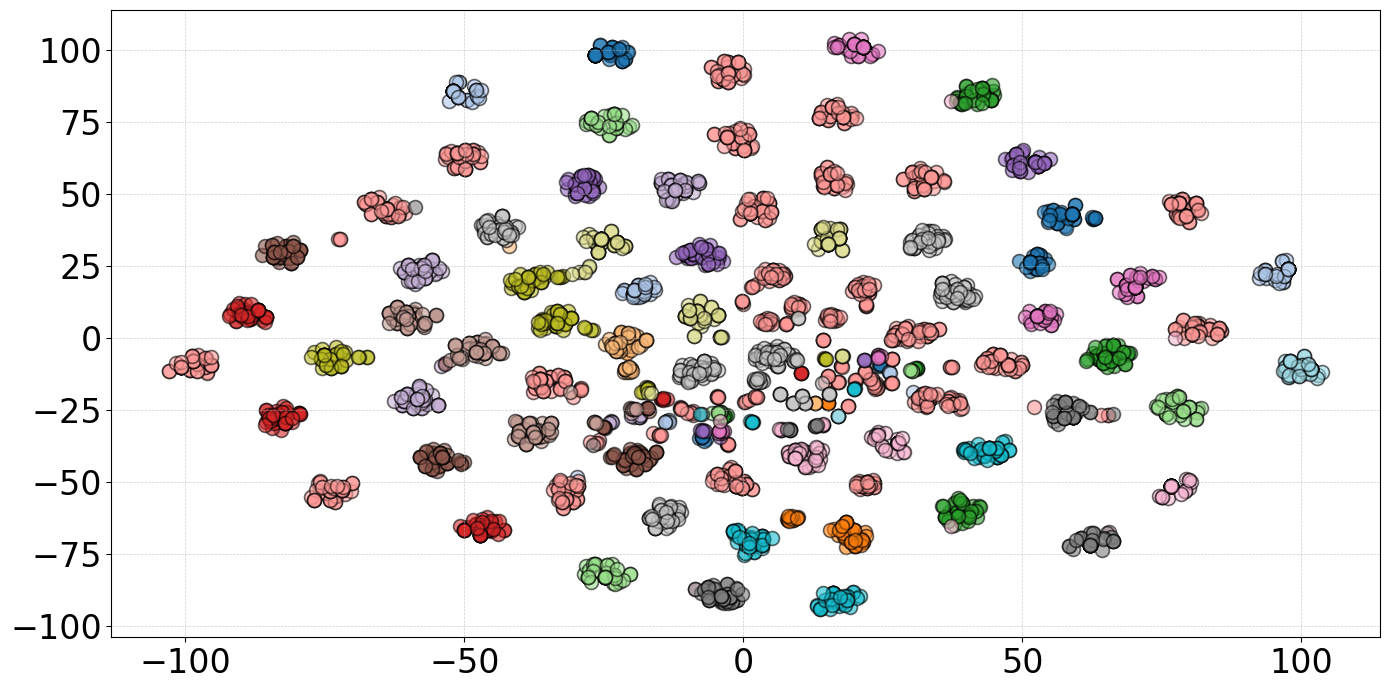

In [9]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 'filtered_data_plot.csv' 읽기
filtered_data = pd.read_csv('filtered_data_plot.csv')

# 데이터 토큰화
filtered_encodings = tokenizer(list(filtered_data['tag_description']), truncation=True, padding=True, return_tensors='pt')

# BERT 임베딩 계산 함수
def get_bert_embeddings(model, encodings, device):
    model.eval()
    with torch.no_grad():
        input_ids = encodings['input_ids'].to(device)
        attention_mask = encodings['attention_mask'].to(device)
        outputs = model.bert(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state.mean(dim=1).cpu().numpy()  # 각 문장의 평균 임베딩 추출

# BERT 모델로 임베딩 계산
bert_embeddings = get_bert_embeddings(model, filtered_encodings, device)

# t-SNE 차원 축소
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(bert_embeddings)

# 시각화를 위한 준비
unique_patterns = filtered_data['pattern'].unique()
color_map = plt.get_cmap('tab20', len(unique_patterns))
pattern_to_color = {pattern: idx for idx, pattern in enumerate(unique_patterns)}

plt.figure(figsize=(14, 7))

# 각 패턴별로 시각화
for pattern, color_idx in pattern_to_color.items():
    pattern_indices = filtered_data['pattern'] == pattern
    plt.scatter(tsne_results[pattern_indices, 0], tsne_results[pattern_indices, 1], 
                color=color_map(color_idx), marker='o', s=100, alpha=0.6, edgecolor='k', linewidth=1.2)

# 그래프 설정
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.6)
plt.tight_layout()
plt.show()
